# 3D-BPP

## Pre-requisites

In [2]:
import os
from collections import namedtuple
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
from ortools.sat.python import cp_model
from matplotlib import pyplot as plt
from tqdm import tqdm

from src import config, dataset, main, utils, bins

In [3]:
%matplotlib notebook
%load_ext autoreload
%load_ext nb_black
%autoreload 2

<IPython.core.display.Javascript object>

In [4]:
plt.style.use("seaborn")
np.random.seed(config.RANDOM_SEED)

<IPython.core.display.Javascript object>

## Pallets and containers

Pallet EUR:

|       |  $L\times W\times H (cm)$   | Load (kg)  |
|:-----:|:--------------------------:|:--------:|
| EUR 1 |  $80\times 120\times 14.5$ |  $2490$  |
| EUR 2 | $120\times 100\times 14.4$ |  $1470$  |
| EUR 3 | $100\times 120\times 14.4$ |  $1920$  |
| EUR 6 |  $80\times 60\times 14.4$  |   $500$  |

Container ISO:

|   |  $L\times W\times H (cm)$  | Load (kg) |
|:-:|:--------------------------:|:--------:|
| 1A | $233\times 1200\times 220$ |  $26480$ |
| 1C |  $233\times 587\times 220$ |  $28180$ |

## Dataset

### Products

In [5]:
product_dataset = dataset.ProductDataset(
    "data/products.pkl",
    config.NUM_PRODUCTS,
    config.MIN_PRODUCT_WIDTH,
    config.MAX_PRODUCT_WIDTH,
    config.MIN_PRODUCT_DEPTH,
    config.MAX_PRODUCT_DEPTH,
    config.MIN_PRODUCT_HEIGHT,
    config.MAX_PRODUCT_HEIGHT,
    config.MIN_PRODUCT_WEIGHT,
    config.MAX_PRODUCT_WEIGHT,
    force_overload=False,
)
product_dataset.products.head()

,width,depth,height,weight,volume
0,160,280,233,8,10438400
1,199,269,260,11,13918060
2,187,101,283,2,5345021
3,126,149,214,2,4017636
4,248,132,280,3,9166080


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


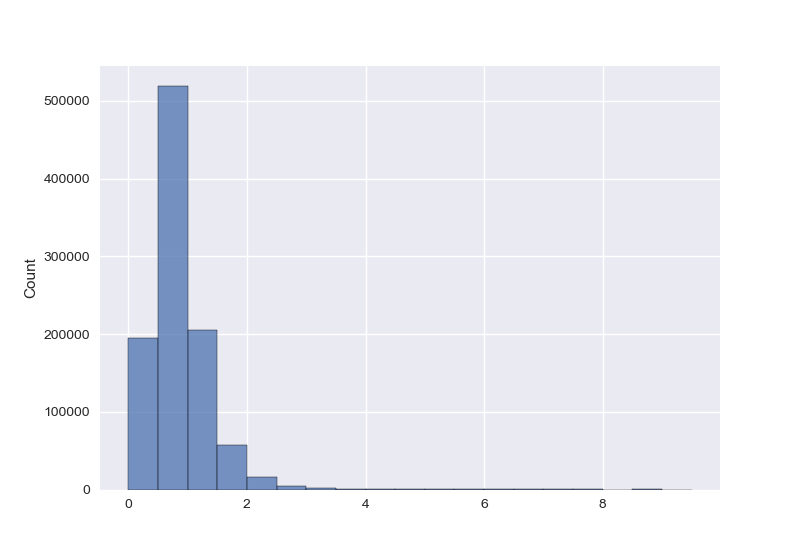

<IPython.core.display.Javascript object>

In [5]:
plt.figure()
sns.histplot(
    product_dataset.products.depth / product_dataset.products.width,
    bins=np.arange(0, 10, 0.5),
)
plt.show()

<IPython.core.display.Javascript object>


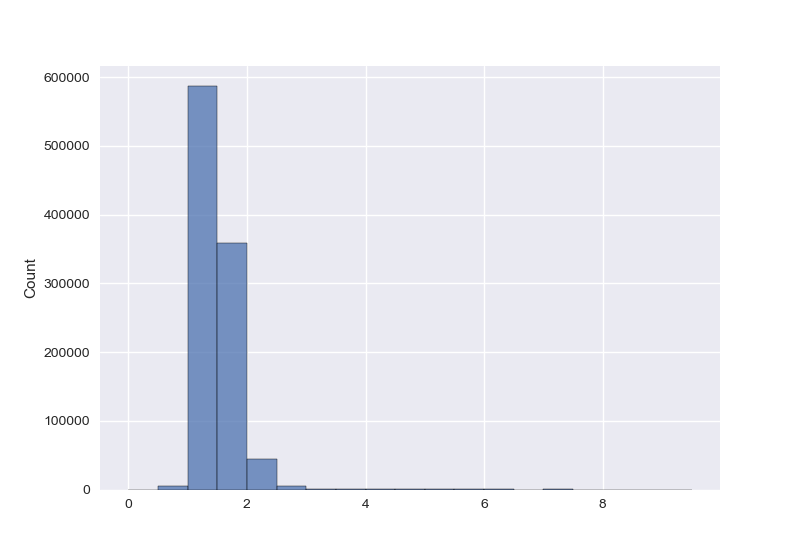

<IPython.core.display.Javascript object>

In [6]:
plt.figure()
sns.histplot(
    product_dataset.products.height / product_dataset.products.width,
    bins=np.arange(0, 10, 0.5),
)
plt.show()

<IPython.core.display.Javascript object>


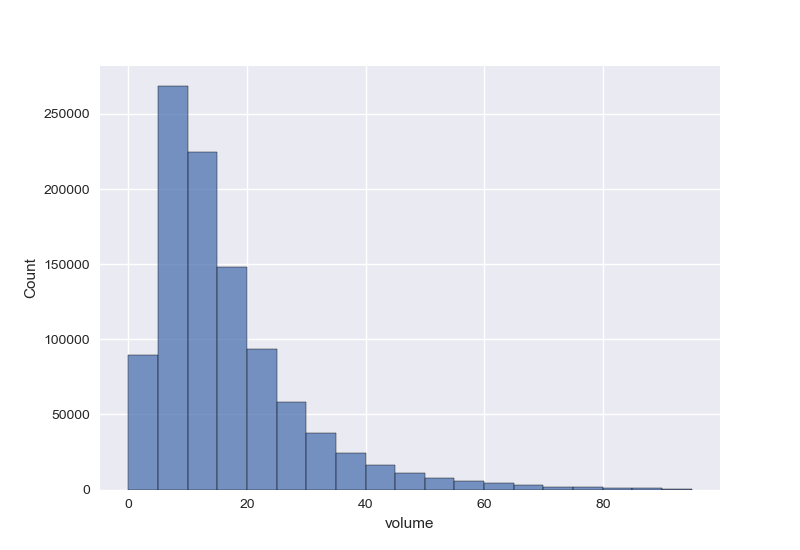

<IPython.core.display.Javascript object>

In [7]:
plt.figure()
sns.histplot(product_dataset.products.volume / 1e6, bins=np.arange(0, 100, 5))
plt.show()

<IPython.core.display.Javascript object>


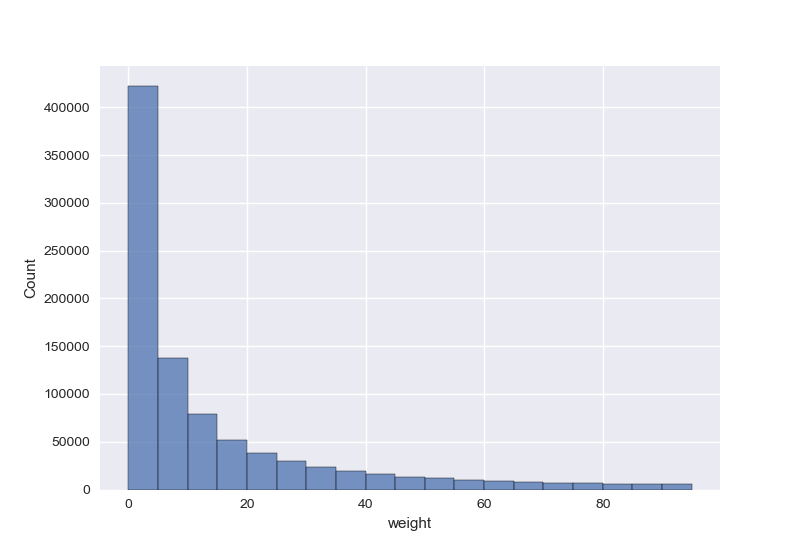

<IPython.core.display.Javascript object>

In [8]:
plt.figure()
sns.histplot(product_dataset.products.weight, bins=np.arange(0, 100, 5))
plt.show()

### Order

In [47]:
ordered_products = 50
order = product_dataset.get_order(ordered_products)
# order = product_dataset.get_dummy_order(ordered_products)
order.head()

,id,width,depth,height,weight,volume
0,492148,274,152,322,417,13410656
1,632413,185,224,250,6,10360000
2,917154,300,89,411,42,10973700
3,368226,137,145,223,2,4429895
4,3696,266,167,353,449,15680966


<IPython.core.display.Javascript object>

## Martello's lower bounds

In [8]:
utils.get_l0_lb(order, config.PALLET_DIMS)

1.0

<IPython.core.display.Javascript object>

In [9]:
utils.get_l1_lb(order, config.PALLET_DIMS)

(0.0, 0.0, 0.0, 0.0)

<IPython.core.display.Javascript object>

In [10]:
utils.get_l2_lb(order, config.PALLET_DIMS)

100it [00:00, 204.90it/s]
100it [00:00, 228.45it/s]
100it [00:00, 228.52it/s]


(1.0, 1.0, 1.0, 1.0)

<IPython.core.display.Javascript object>

## Baseline

In [11]:
bl_layer_pool = main.baseline_procedure(order)
bl_layer_pool.to_dataframe()

Generating vertical superitems: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Items not covered: 0/10


,item,x,y,z,width,depth,height,layer
0,0,353,0,0,343,263,411,0
1,1,0,0,0,294,136,440,0
2,2,0,136,0,180,57,234,0
3,3,0,193,0,176,100,225,0
4,4,180,136,0,173,179,248,0
5,5,0,315,0,202,210,349,0
6,6,0,525,0,366,256,654,0
7,7,366,263,0,277,192,416,0
8,8,643,263,0,286,162,450,0
9,9,929,0,0,249,237,318,0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


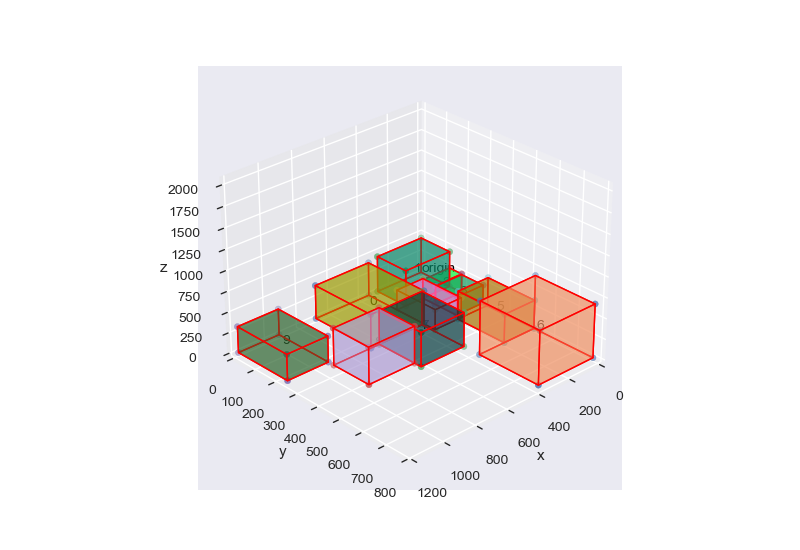

<IPython.core.display.Javascript object>

In [12]:
bl_bin_pool = bins.BinPool(bl_layer_pool, config.PALLET_DIMS)
bl_bin_pool.plot()

## Maxrects

In [48]:
mr_layer_pool = main.maxrect_procedure(order)
mr_layer_pool.to_dataframe()

Generating vertical superitems: 100%|██████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

Height group 1/6
Height group 2/6
Height group 3/6
Height group 4/6
Height group 5/6
Height group 6/6
6
Density 6
Coverage 1
Duplicates 1
Empty 1
1
Items not covered: 34/50


,item,x,y,z,width,depth,height,layer
0,11,0,0,0,185,512,325,0
1,39,0,512,0,248,280,363,0
2,12,185,0,0,216,436,313,0
3,7,185,436,0,219,76,360,0
4,43,248,512,0,228,286,362,0
5,49,401,0,0,260,222,345,0
6,21,401,222,0,264,189,313,0
7,40,661,0,0,238,191,360,0
8,30,899,0,0,161,344,349,0
9,23,665,191,0,234,184,361,0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


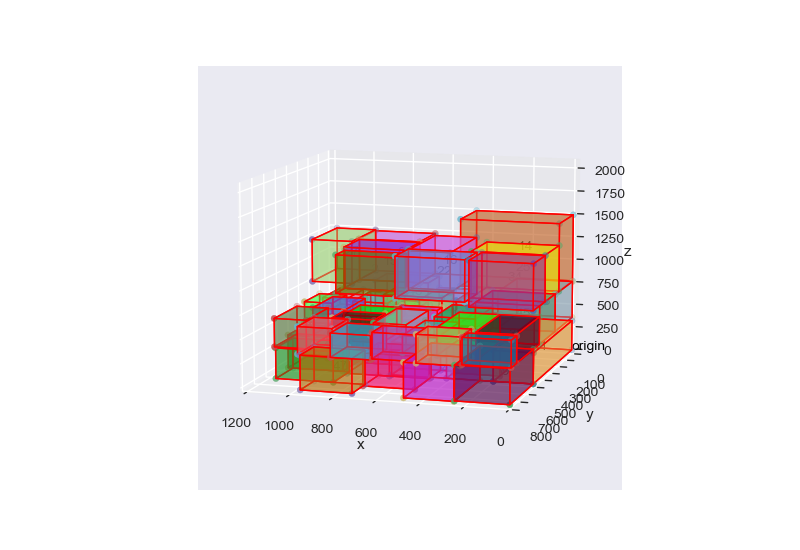

<IPython.core.display.Javascript object>

In [51]:
mr_bin_pool = bins.BinPool(mr_layer_pool, config.PALLET_DIMS)
mr_bin_pool.plot()

## Column generation

In [50]:
filtered_cg_layer_pool, cg_layer_pool, cg_bins_lbs = main.column_generation_procedure(
    order, use_height_groups=False
)
filtered_cg_layer_pool.to_dataframe()

Height group 1/1
Iteration 1/100
Solving RMP...
RMP objective: 1584.0
Duals: [322. 250. 411. 223. 353. 181. 450. 360. 248. 226. 343. 325. 313. 274.
 726. 444. 427. 266. 251. 346. 373. 313. 445. 361. 271. 492. 397. 460.
 276. 181. 349. 248. 171. 289. 485. 290. 270. 292. 289. 363. 360. 283.
 348. 362. 290. 405. 377. 358. 296. 345.]
RMP time: 3.354
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
Solving SP (no placement)...
SP no placement time: 2.3695800000000004e-05
[2, 3, 4, 5, 6, 7, 10, 15, 17, 19, 20, 22, 23, 24, 25, 27, 28, 31, 32, 34, 35, 36, 37, 40, 41, 42, 44, 46, 47, 48]
Reduced cost: -9631.0
FEASIBILITY:  30
Solving SP (no placement)...
Adding feasibility constraint: num selected <= 29
SP no placement time: 5.9667900000000005e-05
[0, 2, 3, 4, 6, 7, 10, 15, 

,item,x,y,z,width,depth,height
0,2,0,0,0,300,89,411
1,6,300,0,0,303,174,450
2,14,603,0,0,475,190,726
3,15,0,89,0,300,158,444
4,16,300,174,0,207,308,427
5,20,507,190,0,282,132,373
6,22,789,190,0,330,140,445
7,25,507,330,0,347,183,492
8,26,0,247,0,273,238,397
9,27,854,330,0,198,246,460


Iteration 2/100
Solving RMP...
RMP objective: 1584.0
Duals: [322. 250.   0. 223. 353. 181.   0. 360. 248. 226. 343. 325. 313. 274.
   0.   0.   0. 266. 251. 346.   0. 313.   0. 361. 271.   0.   0.   0.
 276. 181. 349. 248. 171. 289.   0. 290. 270. 292. 289.   0. 360. 283.
 348.   0. 290.   0.   0. 358. 296. 345.]
RMP time: 3.452
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0]
Solving SP (no placement)...
SP no placement time: 2.3288600000000003e-05
[0, 1, 3, 4, 5, 7, 8, 9, 10, 17, 18, 19, 21, 23, 24, 28, 30, 31, 32, 33, 35, 36, 37, 40, 41, 42, 44, 47, 48, 49]
Reduced cost: -8418.0
FEASIBILITY:  30
Solving SP (no placement)...
Adding feasibility constraint: num selected <= 29
SP no placement time: 9.1518e-06
[0, 3, 4, 7, 8, 10, 13, 17, 18, 19, 21, 23, 24, 28, 3

,item,x,y,z,width,depth,height
0,11,0,0,0,185,512,325
1,49,0,512,0,260,222,345
2,12,185,0,0,216,436,313
3,7,185,436,0,219,76,360
4,38,260,512,0,184,277,289
5,30,401,0,0,161,344,349
6,4,404,344,0,266,167,353
7,21,444,511,0,264,189,313
8,40,562,0,0,238,191,360
9,0,562,191,0,274,152,322


Iteration 3/100
Solving RMP...
RMP objective: 1584.0
Duals: [322. 250.   0. 223.   0. 181.   0.   0. 248. 226.   0.   0.   0. 274.
   0.   0.   0. 266. 251.   0.   0.   0. 363.   0. 271.   0.   0.   0.
 276. 181.  39. 248. 171. 289.   0.   0. 270.   0.   0. 363.   0. 283.
   0.   0.   0.   0.   0.   0.   0.   0.]
RMP time: 3.418
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
SP no placement time: 1.0960437e-05
[0, 1, 3, 5, 8, 9, 13, 17, 18, 22, 24, 28, 29, 30, 31, 32, 33, 36, 39, 41]
Reduced cost: -4550.0


,item,x,y,z,width,depth,height
0,39,0,0,0,248,280,363
1,30,0,280,0,161,344,349
2,22,0,624,0,330,140,445
3,13,161,280,0,203,237,274
4,36,161,517,0,210,105,270
5,0,330,622,0,274,152,322
6,33,248,0,0,192,240,289
7,1,364,240,0,185,224,250
8,24,364,464,0,194,50,271
9,28,371,514,0,219,64,276


Iteration 4/100
Solving RMP...
RMP objective: 1532.0
Duals: [  0.   0.   0.   0.   0.   0. 313.   0.   0.   0.   0. 325.   0.   0.
   0.   0.   0. 175.   0.   0. 198.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0. 270.   0.   0.   0.   0.   0.
   0.   0.   0. 215.   0.  88.   0.   0.]
RMP time: 3.508
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
Solving SP (no placement)...
SP no placement time: 7.455681e-06
[6, 11, 17, 20, 36, 45, 47]
Reduced cost: -1134.0


,item,x,y,z,width,depth,height
0,11,0,0,0,185,512,325
1,45,0,512,0,299,202,405
2,6,185,0,0,303,174,450
3,20,185,174,0,282,132,373
4,47,185,306,0,241,124,358
5,17,299,430,0,152,234,266
6,36,426,306,0,210,105,270


Iteration 5/100
Solving RMP...
RMP objective: 1532.0
Duals: [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0. 208.   0. 127.   0.   0.   0.   0. 403. 196.   0.
   0.   0.   0.   0.   0. 289.   0.   0.   0.   0.   0.   0.   0.   0.
  38.   0.   0.   0.   0. 323.   0.   0.]
RMP time: 3.65
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0]
Solving SP (no placement)...
SP no placement time: 4.917641000000001e-06
[18, 20, 25, 26, 33, 42, 47]
Reduced cost: -1094.0


,item,x,y,z,width,depth,height
0,26,0,0,0,273,238,397
1,25,0,238,0,347,183,492
2,20,273,0,0,282,132,373
3,42,273,132,0,187,104,348
4,33,0,421,0,192,240,289
5,47,0,661,0,241,124,358
6,18,192,421,0,171,182,251


Iteration 6/100
Solving RMP...
RMP objective: 1532.0
Duals: [  0. 250.   0.   0.   0.   0.  17.   0.   0.   0.  88. 325.   0.  18.
   0.   0. 217.   0.   0.   0. 108.   0.   0.   0.   0. 384.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 177.
   0.   0.   0.   0.   0.   0.   0.   0.]
RMP time: 3.594
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
SP no placement time: 1.3411969000000002e-05
[1, 6, 10, 11, 13, 16, 20, 25, 41]
Reduced cost: -1095.0


,item,x,y,z,width,depth,height
0,11,0,0,0,185,512,325
1,25,0,512,0,347,183,492
2,16,185,0,0,207,308,427
3,6,185,308,0,303,174,450
4,13,392,0,0,203,237,274
5,1,347,482,0,185,224,250
6,20,488,237,0,282,132,373
7,10,595,0,0,242,151,343
8,41,770,151,0,161,147,283


Iteration 7/100
Solving RMP...
RMP objective: 1532.0
Duals: [  0.           0.           0.           0.           0.
   0.           0.         360.           0.           0.
   0.           0.           1.           0.           0.
   0.           0.           0.           0.           0.
 167.33333333   0.           0.           0.         242.66666667
 122.33333333 202.33333333   0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.         202.33333333   0.           0.           0.
 282.66666667   0.           0.           0.           0.        ]
RMP time: 3.697
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement

,item,x,y,z,width,depth,height
0,12,0,0,0,216,436,313
1,26,0,436,0,273,238,397
2,7,0,674,0,219,76,360
3,24,0,750,0,194,50,271
4,25,216,0,0,347,183,492
5,45,216,183,0,299,202,405
6,20,273,385,0,282,132,373
7,41,515,183,0,161,147,283


Iteration 8/100
Solving RMP...
RMP objective: 1532.0
Duals: [  0.    0.  158.4   0.  186.2   0.    0.    0.    0.  226.    0.   75.6
   0.    0.    0.    0.   75.6   0.    0.    0.    0.    0.    0.    0.
   0.  340.8   0.    0.    0.    0.    0.  147.    0.    0.    0.    0.
  72.    0.    0.    0.    0.    0.    0.    0.    0.  151.2   0.  151.2
   0.    0. ]
RMP time: 3.786
Stagnation exit :(
Density 2
Coverage 2
Duplicates 2
Empty 2
{0: True, 1: False, 2: True, 3: False, 4: True, 5: False, 6: True, 7: True, 8: False, 9: False, 10: True, 11: True, 12: True, 13: False, 14: True, 15: True, 16: True, 17: False, 18: False, 19: True, 20: True, 21: True, 22: True, 23: True, 24: False, 25: True, 26: True, 27: True, 28: False, 29: False, 30: True, 31: False, 32: False, 33: False, 34: True, 35: True, 36: False, 37: True, 38: True, 39: True, 40: True, 41: False, 42: True, 43: True, 44: True, 45: True, 46: True, 47: True, 48: True, 49: True}
[1, 3, 5, 8, 9, 13, 17, 18, 24, 28, 29, 31, 32, 33, 

,item,x,y,z,width,depth,height,layer
0,11,0,0,0,185,512,325,0
1,49,0,512,0,260,222,345,0
2,12,185,0,0,216,436,313,0
3,7,185,436,0,219,76,360,0
4,38,260,512,0,184,277,289,0
5,30,401,0,0,161,344,349,0
6,4,404,344,0,266,167,353,0
7,21,444,511,0,264,189,313,0
8,40,562,0,0,238,191,360,0
9,0,562,191,0,274,152,322,0


<IPython.core.display.Javascript object>

In [52]:
for i, l in enumerate(cg_layer_pool):
    display(l.to_dataframe())
    print(i)

,item,x,y,z,width,depth,height
0,8,0,0,0,534,214,584
1,21,534,0,0,386,296,525
2,29,920,0,0,273,279,451
3,36,920,279,0,251,189,401
4,43,0,214,0,351,189,418
5,4,351,296,0,298,221,395
6,13,0,403,0,283,217,611
7,40,649,296,0,207,194,413
8,47,856,468,0,285,163,476
9,49,649,490,0,185,151,383


0


,item,x,y,z,width,depth,height
0,8,0,0,0,534,214,584
1,21,534,0,0,386,296,525
2,29,920,0,0,273,279,451
3,36,920,279,0,251,189,401
4,43,0,214,0,351,189,418
5,4,351,296,0,298,221,395
6,13,0,403,0,283,217,611
7,40,649,296,0,207,194,413
8,47,856,468,0,285,163,476
9,49,649,490,0,185,151,383


1


,item,x,y,z,width,depth,height
0,23,0,0,0,228,379,354
1,42,0,379,0,228,316,363
2,44,0,695,0,212,96,331
3,43,228,0,0,351,189,418
4,10,579,0,0,254,208,346
5,7,228,189,0,270,183,365
6,0,833,0,0,229,214,367
7,46,498,208,0,318,139,362
8,1,816,214,0,257,167,355
9,38,498,347,0,223,191,316


2


,item,x,y,z,width,depth,height
0,8,0,0,0,534,214,584
1,21,534,0,0,386,296,525
2,29,920,0,0,273,279,451
3,7,920,279,0,270,183,365
4,0,0,214,0,229,214,367
5,36,229,214,0,251,189,401
6,38,480,296,0,223,191,316
7,2,229,403,0,221,185,337
8,48,0,428,0,135,280,302
9,22,703,296,0,215,173,309


3


,item,x,y,z,width,depth,height
0,4,0,0,0,298,221,395
1,34,0,221,0,172,317,256
2,12,0,538,0,196,251,272
3,1,172,221,0,257,167,355
4,37,172,388,0,253,128,307
5,31,298,0,0,203,192,339
6,48,196,516,0,135,280,302
7,22,331,516,0,215,173,309
8,19,331,689,0,178,105,214
9,20,509,689,0,178,88,228


4


,item,x,y,z,width,depth,height
0,8,0,0,0,534,214,584
1,21,534,0,0,386,296,525
2,42,920,0,0,228,316,363
3,13,0,214,0,283,217,611
4,2,283,214,0,221,185,337
5,46,504,296,0,318,139,362
6,40,283,399,0,207,194,413
7,30,0,431,0,241,162,448
8,18,822,316,0,314,140,469
9,35,490,435,0,237,140,369


5


,item,x,y,z,width,depth,height
0,23,0,0,0,228,379,354
1,34,0,379,0,172,317,256
2,20,0,696,0,178,88,228
3,12,172,379,0,196,251,272
4,47,178,630,0,285,163,476
5,36,228,0,0,251,189,401
6,26,228,189,0,260,146,331
7,22,479,0,0,215,173,309
8,48,368,335,0,135,280,302
9,37,488,173,0,253,128,307


6


,item,x,y,z,width,depth,height
0,8,0,0,0,534,214,584
1,21,534,0,0,386,296,525
2,29,920,0,0,273,279,451
3,42,920,279,0,228,316,363
4,38,0,595,0,223,191,316
5,34,223,214,0,172,317,256
6,40,0,214,0,207,194,413
7,22,0,408,0,215,173,309
8,0,223,531,0,229,214,367
9,14,395,296,0,268,139,422


7


,item,x,y,z,width,depth,height
0,29,0,0,0,273,279,451
1,42,0,279,0,228,316,363
2,18,0,595,0,314,140,469
3,10,228,279,0,254,208,346
4,44,228,487,0,212,96,331
5,0,314,583,0,229,214,367
6,40,273,0,0,207,194,413
7,30,480,0,0,241,162,448
8,19,480,162,0,178,105,214
9,11,482,267,0,127,305,189


8


,item,x,y,z,width,depth,height
0,23,0,0,0,228,379,354
1,42,0,379,0,228,316,363
2,44,0,695,0,212,96,331
3,13,228,0,0,283,217,611
4,10,511,0,0,254,208,346
5,7,765,0,0,270,183,365
6,0,765,183,0,229,214,367
7,31,994,183,0,203,192,339
8,39,994,375,0,198,149,342
9,38,511,208,0,223,191,316


9


,item,x,y,z,width,depth,height
0,21,0,0,0,386,296,525
1,29,0,296,0,273,279,451
2,10,0,575,0,254,208,346
3,38,254,575,0,223,191,316
4,2,273,296,0,221,185,337
5,30,477,481,0,241,162,448
6,39,477,643,0,198,149,342
7,33,675,643,0,183,154,286
8,48,386,0,0,135,280,302
9,49,494,280,0,185,151,383


10


,item,x,y,z,width,depth,height
0,21,0,0,0,386,296,525
1,29,0,296,0,273,279,451
2,7,0,575,0,270,183,365
3,0,270,575,0,229,214,367
4,40,273,296,0,207,194,413
5,22,386,0,0,215,173,309
6,11,480,173,0,127,305,189
7,39,601,0,0,198,149,342
8,32,499,478,0,156,195,280
9,33,607,149,0,183,154,286


11


,item,x,y,z,width,depth,height
0,8,0,0,0,534,214,584
1,10,534,0,0,254,208,346
2,7,788,0,0,270,183,365
3,28,1058,0,0,103,196,229
4,2,788,183,0,221,185,337
5,33,1009,196,0,183,154,286
6,49,1009,350,0,185,151,383
7,35,534,208,0,237,140,369
8,46,0,214,0,318,139,362
9,39,318,214,0,198,149,342


12


,item,x,y,z,width,depth,height
0,21,0,0,0,386,296,525
1,7,0,296,0,270,183,365
2,46,0,479,0,318,139,362
3,18,270,296,0,314,140,469
4,30,0,618,0,241,162,448
5,6,241,618,0,251,133,399
6,33,318,436,0,183,154,286
7,38,492,590,0,223,191,316
8,44,501,436,0,212,96,331
9,5,386,0,0,151,219,307


13


,item,x,y,z,width,depth,height
0,29,0,0,0,273,279,451
1,42,0,279,0,228,316,363
2,30,0,595,0,241,162,448
3,10,228,279,0,254,208,346
4,12,273,0,0,196,251,272
5,14,469,0,0,268,139,422
6,35,469,139,0,237,140,369
7,39,241,487,0,198,149,342
8,17,241,636,0,156,131,237
9,28,439,487,0,103,196,229


14


,item,x,y,z,width,depth,height
0,8,0,0,0,534,214,584
1,29,534,0,0,273,279,451
2,42,0,214,0,228,316,363
3,2,228,214,0,221,185,337
4,40,807,0,0,207,194,413
5,28,1014,0,0,103,196,229
6,25,807,194,0,190,146,365
7,19,997,196,0,178,105,214
8,22,449,279,0,215,173,309
9,35,664,340,0,237,140,369


15


,item,x,y,z,width,depth,height
0,29,0,0,0,273,279,451
1,10,0,279,0,254,208,346
2,47,0,487,0,285,163,476
3,18,0,650,0,314,140,469
4,14,254,279,0,268,139,422
5,16,285,418,0,205,170,218
6,35,314,588,0,237,140,369
7,45,314,728,0,171,70,298
8,33,490,418,0,183,154,286
9,44,551,572,0,212,96,331


16


,item,x,y,z,width,depth,height
0,42,0,0,0,228,316,363
1,10,0,316,0,254,208,346
2,0,228,0,0,229,214,367
3,38,0,524,0,223,191,316
4,14,223,524,0,268,139,422
5,6,223,663,0,251,133,399
6,19,474,663,0,178,105,214
7,15,254,214,0,193,172,228
8,49,447,214,0,185,151,383
9,28,457,0,0,103,196,229


17


,item,x,y,z,width,depth,height
0,42,0,0,0,228,316,363
1,18,0,316,0,314,140,469
2,2,228,0,0,221,185,337
3,20,228,185,0,178,88,228
4,40,0,456,0,207,194,413
5,14,0,650,0,268,139,422
6,6,207,456,0,251,133,399
7,39,314,273,0,198,149,342
8,49,268,589,0,185,151,383
9,27,453,589,0,153,136,229


18


,item,x,y,z,width,depth,height
0,21,0,0,0,386,296,525
1,42,0,296,0,228,316,363
2,14,0,612,0,268,139,422
3,22,228,296,0,215,173,309
4,35,228,469,0,237,140,369
5,16,268,609,0,205,170,218
6,39,386,0,0,198,149,342
7,49,443,149,0,185,151,383


19


,item,x,y,z,width,depth,height
0,8,0,0,0,534,214,584
1,29,534,0,0,273,279,451
2,10,0,214,0,254,208,346
3,0,254,214,0,229,214,367
4,11,0,422,0,127,305,189
5,15,807,0,0,193,172,228
6,39,1000,0,0,198,149,342
7,33,1000,149,0,183,154,286


20


,item,x,y,z,width,depth,height
0,8,0,0,0,534,214,584
1,21,534,0,0,386,296,525
2,6,920,0,0,251,133,399
3,33,920,133,0,183,154,286
4,25,920,287,0,190,146,365
5,44,0,214,0,212,96,331
6,45,212,214,0,171,70,298


21


,item,x,y,z,width,depth,height
0,42,0,0,0,228,316,363
1,12,0,316,0,196,251,272
2,0,0,567,0,229,214,367
3,46,196,316,0,318,139,362
4,44,196,455,0,212,96,331
5,18,229,551,0,314,140,469
6,6,228,0,0,251,133,399
7,33,228,133,0,183,154,286
8,28,479,0,0,103,196,229


22


,item,x,y,z,width,depth,height
0,42,0,0,0,228,316,363
1,36,0,316,0,251,189,401
2,40,228,0,0,207,194,413
3,45,228,194,0,171,70,298
4,6,0,505,0,251,133,399
5,39,0,638,0,198,149,342
6,33,198,638,0,183,154,286


23


,item,x,y,z,width,depth,height
0,8,0,0,0,534,214,584
1,10,534,0,0,254,208,346
2,18,788,0,0,314,140,469
3,38,788,140,0,223,191,316
4,33,1011,140,0,183,154,286
5,45,1011,294,0,171,70,298


24


,item,x,y,z,width,depth,height
0,29,0,0,0,273,279,451
1,0,0,279,0,229,214,367
2,46,0,493,0,318,139,362
3,33,0,632,0,183,154,286
4,49,183,632,0,185,151,383
5,45,229,279,0,171,70,298


25


<IPython.core.display.Javascript object>

In [139]:
cg_layer_pool[39].superitems_pool.to_dataframe()

,width,depth,height,ids,type
0,352,259,457,[5],SingleItemSuperitem
1,345,191,446,[0],SingleItemSuperitem
2,345,191,845,"[0, 6]",VerticalSuperitem
3,378,126,489,[9],SingleItemSuperitem
4,330,191,399,[6],SingleItemSuperitem
5,210,182,324,[4],SingleItemSuperitem
6,149,165,246,[16],SingleItemSuperitem
7,135,165,198,[19],SingleItemSuperitem
8,190,181,285,[1],SingleItemSuperitem
9,154,142,266,[13],SingleItemSuperitem


<IPython.core.display.Javascript object>

In [134]:
zsl = cg_layer_pool.get_zsl()[:, 39]

<IPython.core.display.Javascript object>

In [138]:
fsi, _, _ = cg_layer_pool.superitems_pool.get_fsi()
print(fsi.shape)

(31, 20)


<IPython.core.display.Javascript object>

In [140]:
for i in range(20):
    print(sum([fsi[s, i] * zsl[s] for s in range(31)]) <= 1)

False
True
True
True
True
True
False
False
False
True
True
False
False
True
True
True
False
True
True
False


<IPython.core.display.Javascript object>

In [75]:
filtered_cg_layer_pool.to_dataframe()

,item,x,y,z,width,depth,height,layer
0,23,0,0,0,228,379,354,0
1,42,0,379,0,228,316,363,0
2,44,0,695,0,212,96,331,0
3,10,228,0,0,254,208,346,0
4,7,482,0,0,270,183,365,0
5,0,752,0,0,229,214,367,0
6,1,482,183,0,257,167,355,0
7,38,228,208,0,223,191,316,0
8,31,981,0,0,203,192,339,0
9,48,981,192,0,135,280,302,0


<IPython.core.display.Javascript object>

In [76]:
print(filtered_cg_layer_pool.get_densities(two_dims=False))
print(filtered_cg_layer_pool.get_densities(two_dims=True))

[0.7833481933152665, 0.6613250630796509]
[0.8421510416666667, 0.8478447916666667]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


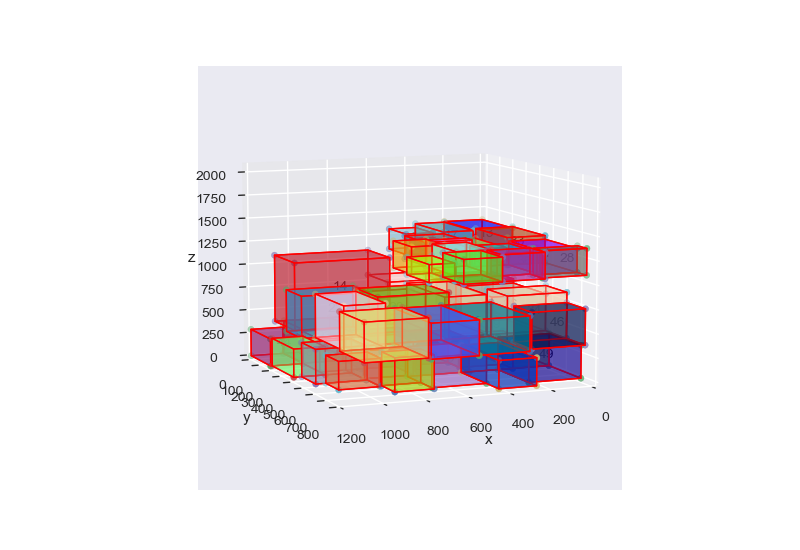

<IPython.core.display.Javascript object>

In [56]:
cg_bin_pool = bins.BinPool(filtered_cg_layer_pool, config.PALLET_DIMS)
cg_bin_pool.plot()

In [ ]:
np.floor(np.mean(cg_bins_lbs) / config.PALLET_HEIGHT)

## Comparison

In [57]:
print("CG")
print(cg_bin_pool.get_heights())
print(filtered_cg_layer_pool.get_densities(two_dims=False))
print("MR")
print(mr_bin_pool.get_heights())
print(mr_layer_pool.get_densities(two_dims=False))

CG
[1376]
[0.7764245152354571, 0.5303829703282829, 0.4126243187716263]
MR
[1494]
[0.7805969123048668, 0.6100157664609054, 0.3501138429752066]


<IPython.core.display.Javascript object>